# Branching in the models

The reason why is functional API prefered.

## Defining layers out of order

Some models uses branching, it is really common especially for famous image processing architecture, like GoogLeNet network using Inception modules.

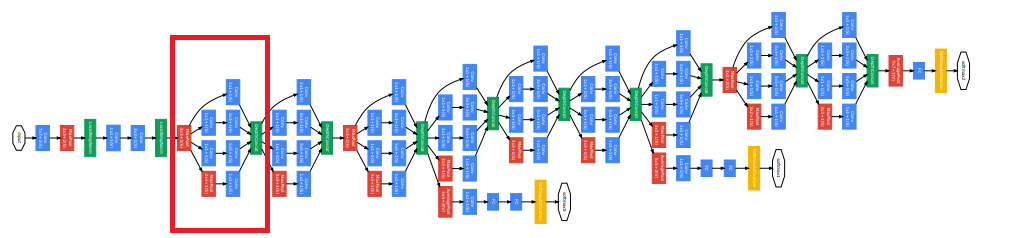

For image processing architectures is usually large part of work choosing right layer and configuration to apply, that could differ between the pictures. So authors of inception module decided to go wider rather than deeper.

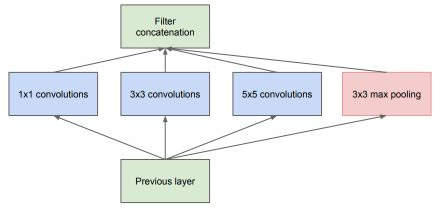

And architecture like this is impossible to create just by stacking layers one by one.

## Simple branching example in code

In [ ]:
from tensorflow import keras
# importing Dense, Input layer but also a concatenate layer that concatenate outputs from specified branches
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.models import Model

In [ ]:
# input layer with 3 features
input_layer = Input(shape=(3,))
# first branch
branch_1 = Dense(32, activation='relu')(input_layer)
# second branch
branch_2 = Dense(64, activation='relu')(input_layer)
# third branch
branch_3 = Dense(128, activation='relu')(input_layer)
# merging branches together
merge = concatenate([branch_1, branch_2, branch_3])
# outputing results from the network
output_layer = Dense(1)(merge)
model = Model(inputs = input_layer, outputs = output_layer)

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Keras allows merging branches using **concatenate** layer. 

This allows us:
* process data in multiple branches
* have multiple independent inputs (for example sound and image - multimodal architecture)
* multiple independet outputs

## Multi-output model with energy efficiency data set

We will be using https://archive.ics.uci.edu/ml/datasets/Energy+efficiency dataset.

### Data processing

Dataset is in form of MS Excel file, has 8 input features:
* X1 Relative Compactness
* X2 Surface Area
* X3 Wall Area
* X4 Roof Area
* X5 Overall Height
* X6 Orientation
* X7 Glazing Area
* X8 Glazing Area Distribution

And 2 output features:
* y1 Heating Load
* y2 Cooling Load

#### Loading data

In [ ]:
# Dataset path
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

Thankfully pandas has parser for *.xlsx files, so we will use it for loading the data.

However it may need to require to install **openpyxl** library, so lets do it.

In [ ]:
!conda install --yes -c anaconda openpyxl

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel(URL)
display(df)

Shuffle the data befor assigning train/test group.

In [ ]:
# frac means fraction of data to return, so 1 means all of them, 
# reset index is there for reseting index column, so it is nicely monotonic increasing, it will not be using during traning
df = df.sample(frac=1).reset_index(drop=True)
display(df)

### Process the data

#### Shuffle data and split to train/test set 

Split the data for train/test sets by:
* 80% of the data to traing
* 20% of the data to test

In [ ]:
train = df.sample(frac = 0.8)
test = df.drop(train.index)

In [ ]:
train

In [ ]:
test

#### Extract labels from the data
Take last two columns as a label - pop returns the column and deletes it in the original data.

In [ ]:
train_Y = (train.pop('Y1'), train.pop('Y2'))
test_Y = (test.pop('Y1'), test.pop('Y2'))

In [ ]:
train_Y

#### Normalization of the data

$$ {X - \mu \over \sigma} $$

In [ ]:
def norm(x, x_mean, x_std):
    # subtract mean and divide by standard deviation using broadcasting
    return (x - x_mean) / x_std

Get mean and standard deviation values.

In [ ]:
train_stats = train.describe()
display(train_stats)

Transpose the data for easier processing.

In [ ]:
train_stats = train_stats.transpose()
display(train_stats)

Normalize using train data descriptive statistics to prevent lookahead.

In [ ]:
norm_train_X = norm(train, train_stats['mean'], train_stats['std'])
norm_test_X = norm(test, train_stats['mean'], train_stats['std'])
print('Normalized train data')
display(norm_train_X)
print('Normalized test data')
display(norm_test_X)

### Building the model

Define multi-output architecture.

In [ ]:
train.columns

In [ ]:
# set input shape - .columns from pandas returns column list and len gets the length of the list
input_layer = Input(shape=(len(train.columns),))
# hidden layers
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)

# Y2 output will come via the third dense
third_dense = Dense(units=64, activation='relu')(second_dense)
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Setting optimizer and loss function for two outputs.

In [ ]:
# Specify the SGD optimizer, and compile the model with loss functions for both outputs
optimizer = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': keras.metrics.RootMeanSquaredError(),
                       'y2_output': keras.metrics.RootMeanSquaredError()})

### Train model

In [ ]:
%%time
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y, epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

### Evaluate model

Evaluate function output overall loss, y1 and y2 loss and also both metrics.

In [ ]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print(f'Loss = {loss}, Y1_loss = {Y1_loss}, Y1_rmse = {Y1_rmse}, Y2_loss = {Y2_loss}, Y2_rmse = {Y2_rmse}')

#### Plotting progress of loss and metrics functions

In [ ]:
import matplotlib.pyplot as plt

Y1 root mean square error

In [ ]:
plt.title('Y1 RMSE')
plt.ylim(0, 6)
plt.plot(history.history['y1_output_root_mean_squared_error'], color='blue', label='y1_output_root_mean_squared_error')
plt.plot(history.history['val_y1_output_root_mean_squared_error'], color='green', label='val_y1_output_root_mean_squared_error')
plt.legend()
plt.show()

Y2 root mean square error

In [ ]:
plt.title('Y2 RMSE')
plt.ylim(0, 7)
plt.plot(history.history['y2_output_root_mean_squared_error'], color='blue', label='y2_output_root_mean_squared_error')
plt.plot(history.history['val_y2_output_root_mean_squared_error'], color='green', label='val_y2_output_root_mean_squared_error')
plt.legend()
plt.show()

#### Plotting prediction accuracy

Plotting the difference between true values and predictions.

In [ ]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

In [ ]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')